In [2]:
!pip install torch-lr-finder

In [3]:
!pip install split-folders

In [61]:
import os
import torch
import pandas as pd
import random
import seaborn as sns
from PIL import Image


from torch.utils.data import WeightedRandomSampler
from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CyclicLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
from torch.optim import Adam
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix

import splitfolders
import torch.optim as optim 
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [62]:
data_dir = r'E:\Jupyter\Samples\FSamples'

In [65]:
def pad_image(image):
    # Get the dimensions of the image
    width, height = image.size

    # Find the longer side
    max_dim = max(width, height)

    # Create a square background image
    background = Image.new('RGB', (max_dim, max_dim), (255, 255, 255))

    # Calculate the position to paste the original image on the background
    pos = ((max_dim - width) // 2, (max_dim - height) // 2)

    # Paste the original image on the background
    background.paste(image, pos)

    return background

In [66]:
# Image pre-process/Image augmentation
data_transforms = transforms.Compose([
    transforms.Resize(size=(512, 512)),
    transforms.CenterCrop(448),  
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [67]:
class CoffeeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        class_labels = sorted(os.listdir(root_dir))
        for label_idx, label in enumerate(class_labels):
            class_dir = os.path.join(root_dir, label)
            if os.path.isdir(class_dir):
                for img_path in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_path)
                    self.image_paths.append(img_path)
                    label_vector = [0]*len(class_labels)
                    label_vector[label_idx] = 1
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert('RGB')
        
        img = pad_image(img)
        
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label)


In [68]:
dataset = CoffeeDataset(data_dir, transform=data_transforms)
class_labels = sorted(os.listdir(data_dir))
print("Class labels:", class_labels)

Class labels: ['Abiotic', 'Cercospora', 'Leaf Rust', 'Lichens', 'No Disease', 'Sooty Mold', 'Wilt']


In [8]:
splitfolders.ratio("E:\Jupyter\Samples\FSamples",
            output="splitted_data",
            seed=42,
            ratio=(.7, .2, .1),
            group_prefix=None,
            move=False)

Copying files: 1297 files [00:06, 191.62 files/s]


In [9]:
train = datasets.ImageFolder(root="/Jupyter/ML/splitted_data/train",
                              transform=data_transforms)

val = datasets.ImageFolder(root="/Jupyter/ML/splitted_data/val",
                              transform=data_transforms)

test = datasets.ImageFolder(root="/Jupyter/ML/splitted_data/test",
                              transform=data_transforms)

# -------- Getting the Whole Dataset for Visualization Purposes --------
data = datasets.ImageFolder(root="E:\Jupyter\Samples\FSamples",
                              transform=data_transforms)

In [55]:
class_labels = ['Cercospora', 'No Disease', 'Abiotic', 'Leaf Rust', 'Lichens', 'Sooty Mold', 'Wilt']
class_to_idx = {label: idx for idx, label in enumerate(class_labels)}
idx_to_class = {idx: label for label, idx in class_to_idx.items()}

print("Dataset Labels:\n", class_to_idx, "\n")

for name, dataset in zip(["TRAIN", "VALIDATION", "TEST"], [train, val, test]):
    images_per_class = pd.Series([class_to_idx[dataset.classes[target]] for target in dataset.targets]).value_counts()
    print(f"Images per Class in {name}:")
    for idx in sorted(images_per_class.index):
        print(f"{idx}    {idx_to_class[idx]}: {images_per_class[idx]}")
    print()

Dataset Labels:
 {'Cercospora': 0, 'No Disease': 1, 'Abiotic': 2, 'Leaf Rust': 3, 'Lichens': 4, 'Sooty Mold': 5, 'Wilt': 6} 

Images per Class in TRAIN:
0    Cercospora: 320
1    No Disease: 58
2    Abiotic: 37
3    Leaf Rust: 198
4    Lichens: 127
5    Sooty Mold: 91
6    Wilt: 74

Images per Class in VALIDATION:
0    Cercospora: 91
1    No Disease: 16
2    Abiotic: 10
3    Leaf Rust: 56
4    Lichens: 36
5    Sooty Mold: 26
6    Wilt: 21

Images per Class in TEST:
0    Cercospora: 47
1    No Disease: 10
2    Abiotic: 7
3    Leaf Rust: 29
4    Lichens: 19
5    Sooty Mold: 13
6    Wilt: 11



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

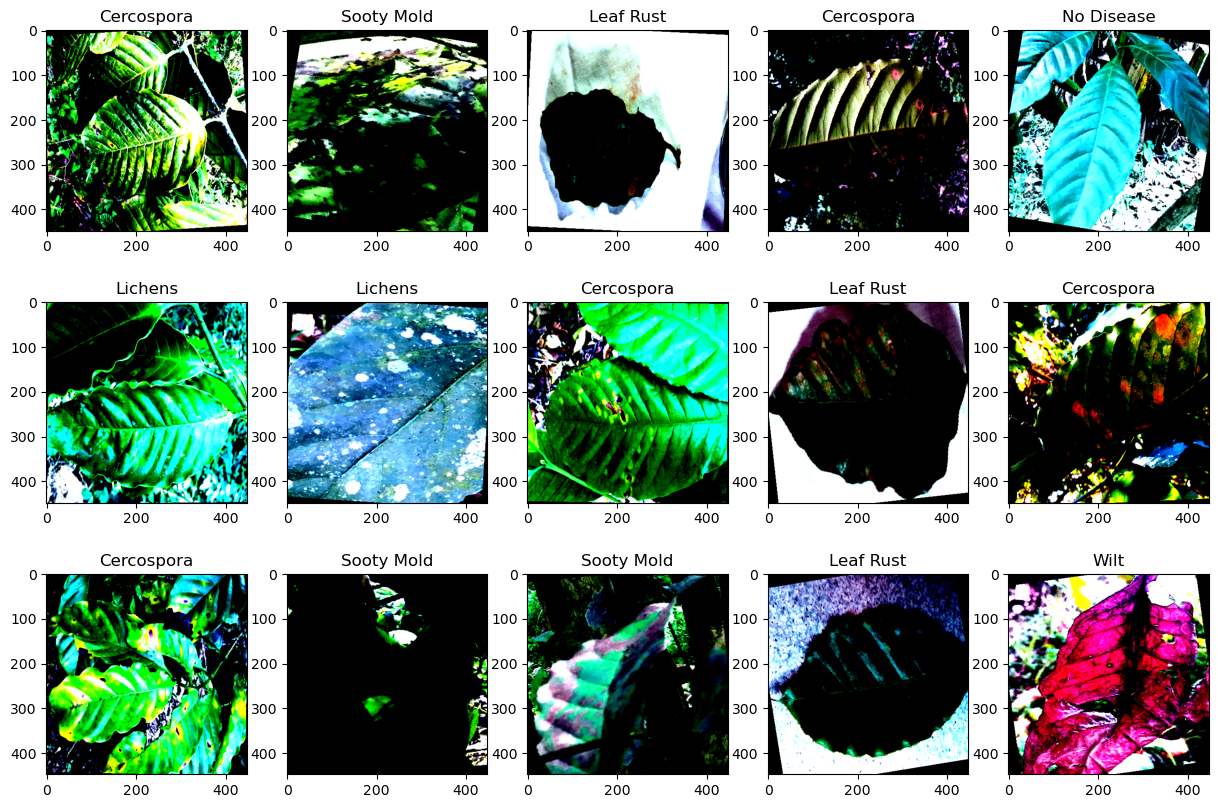

In [11]:
labels_for_viz = {v: k for k, v in data.class_to_idx.items()}

fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for i in range(15):
    sample = random.randint(0, len(data) - 1)
    ax[i].imshow(data[sample][0].permute(1, 2, 0))
    ax[i].title.set_text(labels_for_viz[data[sample][1]])

In [12]:
train_loader = DataLoader(dataset=train,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True)

val_loader = DataLoader(dataset=val,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True)

test_loader = DataLoader(dataset=test,
                             batch_size=32,
                             num_workers=2,
                             shuffle=False)

In [13]:
print("Length of training dataset:", len(train))
print("Length of validation dataset:", len(val))
print("Length of test dataset:", len(test))

Length of training dataset: 905
Length of validation dataset: 256
Length of test dataset: 136


In [14]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in C:\Users\Nicko/.cache\torch\hub\pytorch_vision_v0.10.0
E:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

In [16]:
num_ftrs = resnet.fc.in_features
num_classes = len(class_labels) 
resnet.fc = nn.Linear(num_ftrs, num_classes)

In [17]:
# Create the CNN model
model = resnet

In [18]:
# Check for available GPUs
device = torch.device("cuda")

In [19]:
# Move the model to the GPU
model = model.to("cuda")

In [23]:
total_samples = len(train)
samples_per_class = [len(os.listdir(os.path.join(data_dir, label))) for label in class_labels]

# Print samples per class
print("Samples per class:", samples_per_class)

# Calculate the initial class weights
initial_class_weights = [total_samples / samples_per_class[i] for i in range(len(class_labels))]

# Apply logarithmic scaling
class_weights = [np.log1p(weight) for weight in initial_class_weights]

# Print class weights
print("Initial class weights:", initial_class_weights)
print("Log-scaled class weights:", class_weights)

# Convert class weights to tensor
weights = torch.tensor(class_weights).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)


Samples per class: [458, 84, 54, 283, 182, 130, 106]
Initial class weights: [1.9759825327510918, 10.773809523809524, 16.75925925925926, 3.197879858657244, 4.972527472527473, 6.961538461538462, 8.537735849056604]
Log-scaled class weights: [1.0905742475823477, 2.4658775327793987, 2.876907028319164, 1.4345796022793524, 1.787170200044414, 2.074622255243887, 2.255256124908404]


In [24]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

E:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [25]:
def train_model(model, criterion, optimizer, num_epochs=64, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize lists for saving history
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    # Early stopping details
    early_stopping_counter = 0
    best_loss = float('inf')
    early_stop = False  # Flag to indicate if early stopping occurred

    for epoch in range(num_epochs):
        if early_stop:  # Check if early stopping occurred
            print('Breaking out of epoch loop due to early stopping.')
            break  # Break out of the epoch loop

        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        lr = optimizer.param_groups[0]['lr']
        print(f'Learning Rate: {lr}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader:
                inputs = inputs.cuda()
                labels = labels.cuda().long()

                # Add an extra dimension to labels
                labels = torch.nn.functional.one_hot(labels, num_classes=7).float()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculate the number of correct predictions
                preds = outputs > 0.5
                corrects = (preds == labels).sum().item()
                running_corrects += corrects
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects / (len(data_loader.dataset) * num_classes)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save history
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

            # Check if early stopping conditions are met
            if phase == 'val':
                scheduler.step(epoch_loss)  
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    print(f'Early stopping counter: {early_stopping_counter} out of {patience}')
                    if early_stopping_counter >= patience:
                        model.load_state_dict(best_model_wts)
                        print(f'Early stopping triggered.')
                        early_stop = True  # Set the early stopping flag
                        break  # Break out of the phase loop

    time_elapsed = time.time() - since
    print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, time_elapsed, best_loss, best_acc

model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc = train_model(model, criterion, optimizer, num_epochs=64, patience=5)

torch.save(model.state_dict(), 'model.pth')

print("Training finished...\n")


Epoch 1/64
----------
Learning Rate: 0.001
train Loss: 0.5496 Acc: 0.8687
val Loss: 0.4121 Acc: 0.9102
Epoch 2/64
----------
Learning Rate: 0.001
train Loss: 0.3693 Acc: 0.9081
val Loss: 0.3375 Acc: 0.9163
Epoch 3/64
----------
Learning Rate: 0.001
train Loss: 0.3307 Acc: 0.9149
val Loss: 0.2968 Acc: 0.9191
Epoch 4/64
----------
Learning Rate: 0.001
train Loss: 0.2853 Acc: 0.9212
val Loss: 0.2712 Acc: 0.9375
Epoch 5/64
----------
Learning Rate: 0.001
train Loss: 0.2619 Acc: 0.9258
val Loss: 0.2491 Acc: 0.9431
Epoch 6/64
----------
Learning Rate: 0.001
train Loss: 0.2447 Acc: 0.9324
val Loss: 0.2391 Acc: 0.9336
Epoch 7/64
----------
Learning Rate: 0.001
train Loss: 0.2246 Acc: 0.9361
val Loss: 0.2387 Acc: 0.9347
Epoch 8/64
----------
Learning Rate: 0.001
train Loss: 0.2136 Acc: 0.9403
val Loss: 0.2138 Acc: 0.9353
Epoch 9/64
----------
Learning Rate: 0.001
train Loss: 0.2122 Acc: 0.9410
val Loss: 0.2043 Acc: 0.9397
Epoch 10/64
----------
Learning Rate: 0.001
train Loss: 0.2052 Acc: 0.942

In [26]:
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report

def test_model(model, test_loader, device, class_labels):
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            all_predictions.extend(predicted.to("cpu").numpy())
            all_labels.extend(outputs.to("cpu").numpy())

    # Convert predictions and labels to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Individual models
    models = [
        ('svm', SVC()),
        ('knn', KNeighborsClassifier()),
        ('dt', DecisionTreeClassifier()),
        ('rf', RandomForestClassifier()),
    ]

    for name, model in models:
        model.fit(all_predictions.reshape(-1, 1), all_labels)
        preds = model.predict(all_predictions.reshape(-1, 1))
        print(f"{name.upper()} Classification Report:")
        print(classification_report(all_labels, preds, target_names=class_labels, zero_division=1))

    # Voting Classifier
    voting_model = VotingClassifier(estimators=models, voting='hard')
    voting_model.fit(all_predictions.reshape(-1, 1), all_labels)
    voting_preds = voting_model.predict(all_predictions.reshape(-1, 1))
    print("Voting Classifier Classification Report:")
    print(classification_report(all_labels, voting_preds, target_names=class_labels, zero_division=1))

# Call the function to test the models
test_model(model, test_loader, device, class_labels)


SVM Classification Report:
              precision    recall  f1-score   support

  Cercospora       1.00      0.71      0.83         7
  No Disease       0.77      0.94      0.85        47
     Abiotic       0.97      1.00      0.98        29
   Leaf Rust       0.92      0.63      0.75        19
     Lichens       0.80      0.80      0.80        10
  Sooty Mold       0.80      0.62      0.70        13
        Wilt       1.00      1.00      1.00        11

    accuracy                           0.86       136
   macro avg       0.89      0.81      0.84       136
weighted avg       0.87      0.86      0.86       136

KNN Classification Report:
              precision    recall  f1-score   support

  Cercospora       1.00      0.71      0.83         7
  No Disease       0.77      0.94      0.85        47
     Abiotic       0.97      1.00      0.98        29
   Leaf Rust       0.92      0.63      0.75        19
     Lichens       0.80      0.80      0.80        10
  Sooty Mold       0.80 

In [27]:
def test_model():
    model = models.resnet50(weights = None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 7)

    model = model.to(device)
    model.load_state_dict(torch.load("model.pth"))
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            all_predictions.extend(predicted.to("cpu").numpy())
            all_labels.extend(outputs.to("cpu").numpy())

    print("Test Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_labels))

    # Return a flattened array of all predictions
    return np.array(all_predictions).flatten()

# Call the function to test the model
all_preds = test_model()


Test Classification Report:
              precision    recall  f1-score   support

  Cercospora       1.00      0.71      0.83         7
  No Disease       0.81      0.98      0.88        47
     Abiotic       0.97      1.00      0.98        29
   Leaf Rust       0.93      0.68      0.79        19
     Lichens       0.90      0.90      0.90        10
  Sooty Mold       0.90      0.69      0.78        13
        Wilt       1.00      0.91      0.95        11

    accuracy                           0.89       136
   macro avg       0.93      0.84      0.87       136
weighted avg       0.90      0.89      0.89       136



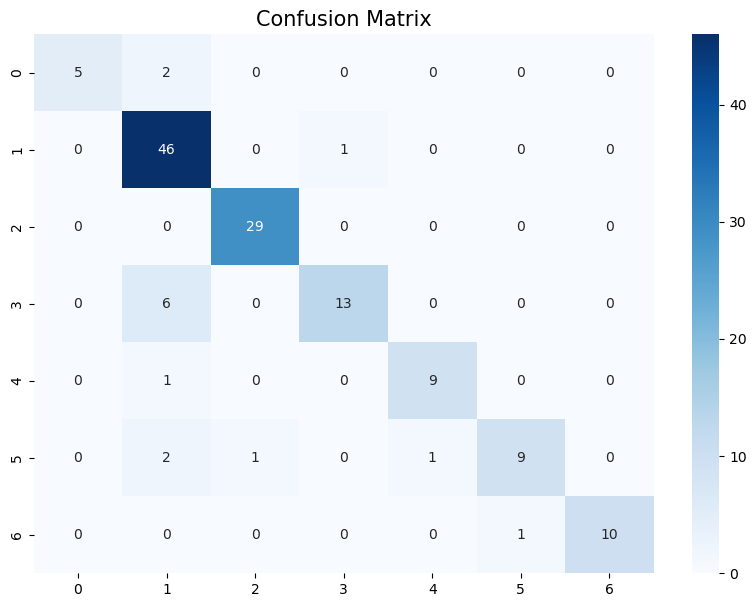

In [28]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(test.targets, all_preds), cmap="Blues", annot=True, fmt="d")
plt.title("Confusion Matrix", size=15)
plt.show()

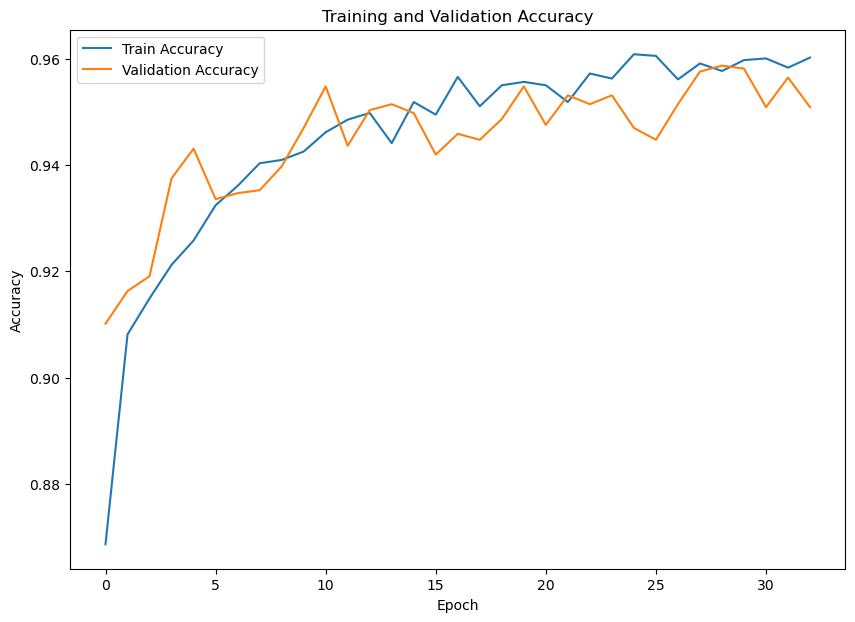

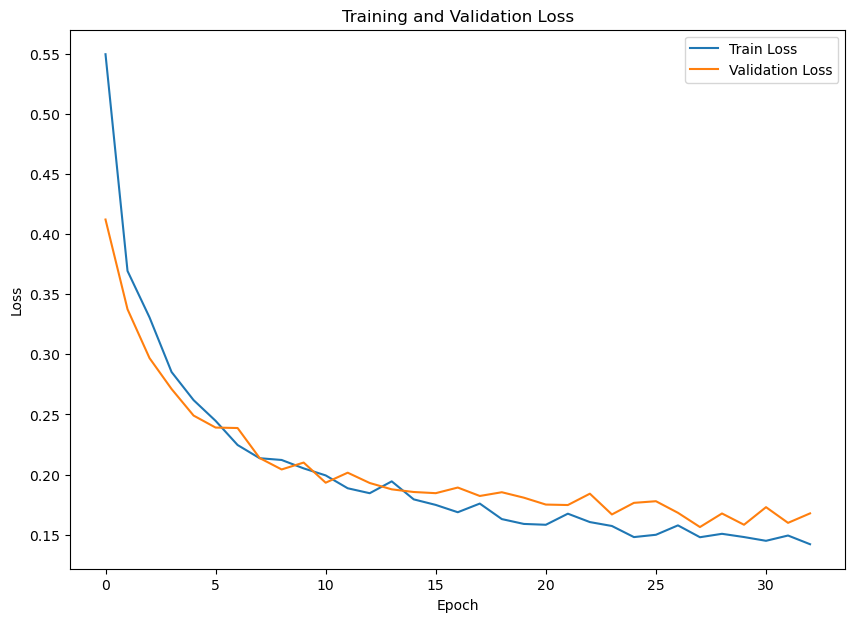

Best val Loss: 0.1564
Best val Acc: 0.9587


In [29]:
def plot_metrics(train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc):
    # Plot accuracy
    plt.figure(figsize=(10, 7))
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Print training time and best metrics
    print(f'Best val Loss: {best_loss:.4f}')
    print(f'Best val Acc: {best_acc:.4f}')

plot_metrics(train_acc_history, val_acc_history, train_loss_history, val_loss_history, training_time, best_loss, best_acc)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


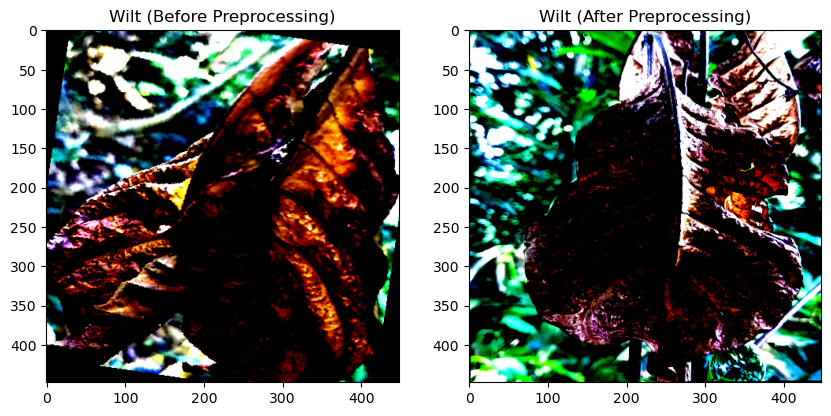

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax = ax.flatten()

ax[0].imshow(data[-1][0].permute(1, 2, 0))
ax[0].title.set_text(f"{labels_for_viz[data[-1][1]]} (Before Preprocessing)")

ax[1].imshow(test[-1][0].permute(1, 2, 0))
ax[1].title.set_text(f"{labels_for_viz[test[-1][1]]} (After Preprocessing)")
plt.show()

In [79]:
import torch
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn
import numpy as np

# Ensure your transformations match the training transformations
data_transforms = transforms.Compose([
    transforms.Resize(size=(512, 512)),
    transforms.CenterCrop(448),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def load_model(model_path, num_classes=7):
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model.load_state_dict(torch.load(model_path))
    model = model.to("cuda")
    model.eval()
    return model

def image_predict(image_path, model, transform, class_labels, threshold=0.5):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to("cuda")

    with torch.no_grad():
        outputs = model(image)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()

        # Print the predicted class labels and their probabilities
        for i, prob in enumerate(probs):
            print(f"{class_labels[i]}: {prob:.4f}")

        confidence_levels = {class_labels[i]: float(probs[i]) for i in range(len(class_labels))}

        # Filter out "No Disease" from class_labels if the probability is not the highest
        highest_prob = np.max(probs)
        highest_class = class_labels[np.argmax(probs)]
        if highest_prob < threshold:
            return f"Uncertain: {highest_class} with confidence {highest_prob:.2f}", confidence_levels

        predicted_labels = [class_labels[i] for i in range(len(class_labels)) if probs[i] > threshold]
        return predicted_labels, confidence_levels

# Usage
model_path = 'model.pth'  # Path to your saved model
model = load_model(model_path)

image_path = 'E:\Jupyter\Samples\FSamples\Sooty Mold\Sample (124).jpg'  # Path to the image you want to predict
predictions, confidences = image_predict(image_path, model, data_transforms, class_labels)

print("Predicted classes:", predictions)
print("Confidence levels:", confidences)


Abiotic: 0.0009
Cercospora: 0.0912
Leaf Rust: 0.0002
Lichens: 0.8763
No Disease: 0.0033
Sooty Mold: 0.4347
Wilt: 0.0000
Predicted classes: ['Lichens']
Confidence levels: {'Abiotic': 0.0009047475759871304, 'Cercospora': 0.09123333543539047, 'Leaf Rust': 0.00020837981719523668, 'Lichens': 0.8763178586959839, 'No Disease': 0.0033274940215051174, 'Sooty Mold': 0.4346924424171448, 'Wilt': 9.508340554020833e-06}
